In [ ]:
'''
Patent Classification/Research
Mario Corado
'''

import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, roc_auc_score, roc_curve, f1_score, recall_score, precision_score,auc, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from pprint import pprint
import time

In [2]:
#Read in datasets via pickle files on Google Drive to save processing time as they are large csv's originally

#Office Actions
df_oa = pd.read_pickle('data\office_actions.pkl')

# Convert Dates
df_oa['mail_dt'] = pd.to_datetime(df_oa['mail_dt'])

# Drop columns early to save RAM
drop_cols = ['header_missing', 'fp_missing', 'closing_missing', 'signature_type']
df_oa.drop(columns=[c for c in drop_cols if c in df_oa.columns], inplace=True)

df_oa.head(10)

<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\o'
C:\Users\mario\AppData\Local\Temp\ipykernel_14508\4258353306.py:4: SyntaxWarning: invalid escape sequence '\o'
  df_oa = pd.read_pickle('data\office_actions.pkl')


,app_id,ifw_number,document_cd,mail_dt,art_unit,uspc_class,uspc_subclass,rejection_fp_mismatch,rejection_101,rejection_102,rejection_103,rejection_112,rejection_dp,objection,allowed_claims,cite102_gt1,cite103_gt3,cite103_eq1,cite103_max
0,14150981,100867762,CTFR,2015-10-15,2632,375,219000,0,0,0,1,0,0,0,0,0,0,1,2
1,14198961,100867788,CTFR,2015-10-15,2699,345,173000,0,0,1,1,0,0,0,0,0,0,0,2
2,13796589,100867794,CTNF,2015-10-15,3776,606,159000,0,0,0,1,0,0,0,0,0,0,0,3
3,14673475,100867844,CTNF,2015-10-15,2627,345,175000,0,0,1,1,1,1,0,0,0,1,0,4
4,14669113,100867850,CTNF,2015-10-15,2666,382,118000,0,1,0,0,1,1,0,0,0,0,0,0
5,14209884,100867853,CTFR,2015-10-15,2676,358,001140,0,0,0,1,0,0,1,1,0,0,0,3
6,14109101,100867858,CTFR,2015-10-15,2657,704,243000,0,0,0,1,0,0,0,0,0,0,0,3
7,13245100,100867884,CTNF,2015-10-15,1789,442,181000,0,0,0,1,1,0,0,0,0,0,0,2
8,13152349,100867886,CTFR,2015-10-13,2443,709,226000,0,0,0,1,0,0,0,0,0,0,0,3
9,13841526,100867893,CTFR,2015-10-15,1736,502,400000,0,0,0,1,0,0,0,0,0,0,0,2


In [3]:
df_oa.shape

(4384532, 19)

In [4]:
df_oa.dtypes

app_id                            int64
ifw_number                       object
document_cd                      object
mail_dt                  datetime64[ns]
art_unit                         object
uspc_class                       object
uspc_subclass                    object
rejection_fp_mismatch             int64
rejection_101                     int64
rejection_102                     int64
rejection_103                     int64
rejection_112                     int64
rejection_dp                      int64
objection                         int64
allowed_claims                    int64
cite102_gt1                       int64
cite103_gt3                       int64
cite103_eq1                       int64
cite103_max                       int64
dtype: object

In [5]:
#Rejections
df_rj = pd.read_pickle('data/rejections.pkl')


df_rj.head(10)

,app_id,ifw_number,action_type,action_subtype,claim_numbers,alice_in,bilski_in,mayo_in,myriad_in
0,12000001,G92WF69VPPOPPY5,103,a,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",0,0,0,0
1,12000001,G92WF69VPPOPPY5,112,b,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",0,0,0,0
2,12000001,GCJ90TE3PPOPPY5,103,a,"6,7,8,9,10,11,12,13,14,15,16",0,0,0,0
3,12000001,GCJ90TE3PPOPPY5,112,b,"6,7,8,9",0,0,0,0
4,12000003,FSZ7OENRPPOPPY5,112,b,4,0,0,0,0
5,12000003,FSZ7OENRPPOPPY5,allowed,NaN,"1,2,3",0,0,0,0
6,12000005,FZVAXT62PPOPPY5,102,b,"1,11,12,13,14,15,16,26,27,28,29",0,0,0,0
7,12000005,FZVAXT62PPOPPY5,103,a,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",0,0,0,0
8,12000005,FZVAXT62PPOPPY5,objected,NaN,"2,3,4,5,6,7,8,9,10,17,18,19,20,21,22,23,24,25",0,0,0,0
9,12000006,GN0WN3S0PPOPPY5,101,Non-Statutory-software,"40,41",0,0,0,0


In [6]:
df_rj.dtypes

app_id             int64
ifw_number        object
action_type       object
action_subtype    object
claim_numbers     object
alice_in           int64
bilski_in          int64
mayo_in            int64
myriad_in          int64
dtype: object

In [7]:
df_rj.shape

(10133179, 9)

In [8]:
import gc
# Process rejections

# Convert 'action_type' strings to binary
df_rj['is_102'] = (df_rj['action_type'].astype(str) == '102').astype(int)
df_rj['is_103'] = (df_rj['action_type'].astype(str) == '103').astype(int)

# Aggregate
# Compress rejection rows into summary stats per ifw_number
rj_agg = df_rj.groupby('ifw_number').agg({
    'action_type': 'count',     # Total issues raised
    'alice_in' : 'max',         # Any Alice rejection
    'bilski_in': 'max',         # Any Bilski rejection
    'is_102': 'sum',            # Count of 102 rejections
    'is_103': 'sum'             # Count of 103 rejections
}).rename(columns={'action_type': 'rejection_count'})

# merge summaries onto the main dataframe
df_oa = df_oa.merge(rj_agg, on='ifw_number', how='left')

# Verify by printing first 5 rows with rejections
# ifw_number should match Office Action IDs
# rejection_count should be a number not NaN
# is_103 should show count of how many times the examiner cited "obviousness" in that letter
print(df_oa[df_oa['rejection_count'] > 0][['ifw_number', 'mail_dt', 'rejection_count', 'is_103', 'alice_in']].head())

# Fill NaNs (office action had 0 rejections)
fill_cols = ['rejection_count', 'alice_in', 'bilski_in', 'is_102', 'is_103']
df_oa[fill_cols] = df_oa[fill_cols].fillna(0)




      ifw_number    mail_dt  rejection_count  is_103  alice_in
65536  102245816 2015-11-25              2.0     1.0       0.0
65537  102245848 2015-11-25              4.0     1.0       0.0
65538  102245853 2015-11-25              1.0     1.0       0.0
65539  102245861 2015-11-25              4.0     0.0       0.0
65540  102245864 2015-11-23              1.0     1.0       0.0


In [9]:
# Deleting rejections dataframe after merge
del df_rj
del rj_agg
gc.collect()

0

In [10]:
#Citations
df_ct = pd.read_pickle('data/citations.pkl')

In [11]:
df_ct.head(10)

,app_id,citation_pat_pgpub_id,parsed,ifw_number,action_type,action_subtype,form892,form1449,citation_in_oa
0,12000001,20060218340,20060218340,NaN,NaN,NaN,0,1,0
1,12000001,2343564,2343564,NaN,NaN,NaN,1,0,0
2,12000001,6622200,6622200,NaN,NaN,NaN,1,0,0
3,12000001,6182004,6182004,NaN,NaN,NaN,0,1,0
4,12000001,2323432,2323432,NaN,NaN,NaN,1,0,0
5,12000001,5694538,5694538,NaN,NaN,NaN,1,0,0
6,12000001,2333454,2333454,NaN,NaN,NaN,1,0,0
7,12000001,20040088473,20040088473,G92WF69VPPOPPY5,103.0,a,1,0,1
8,12000001,20030189860,20030189860,G92WF69VPPOPPY5,103.0,a,1,0,1
9,12000001,20050013154,20050013154,G92WF69VPPOPPY5,103.0,a,1,1,1


In [12]:
df_ct.shape

(58862278, 9)

In [13]:
df_ct.dtypes

app_id                     int64
citation_pat_pgpub_id     object
parsed                    object
ifw_number                object
action_type              float64
action_subtype            object
form892                    int64
form1449                   int64
citation_in_oa             int64
dtype: object

In [14]:
# Aggregate: Count citations per Application ID
ct_agg = df_ct.groupby('app_id').agg({
    'app_id': 'count'
}).rename(columns={'app_id': 'citation_count'})

# Merge onto main dataframe
df_oa = df_oa.merge(ct_agg, on='app_id', how='left')
df_oa['citation_count'] = df_oa['citation_count'].fillna(0)

In [15]:
# Delete citations dataframe
del df_ct
del ct_agg
gc.collect()

0

In [16]:
df_oa.head(5)

,app_id,ifw_number,document_cd,mail_dt,art_unit,uspc_class,uspc_subclass,rejection_fp_mismatch,rejection_101,rejection_102,...,cite102_gt1,cite103_gt3,cite103_eq1,cite103_max,rejection_count,alice_in,bilski_in,is_102,is_103,citation_count
0,14150981,100867762,CTFR,2015-10-15,2632,375,219000,0,0,0,...,0,0,1,2,0.0,0.0,0.0,0.0,0.0,12.0
1,14198961,100867788,CTFR,2015-10-15,2699,345,173000,0,0,1,...,0,0,0,2,0.0,0.0,0.0,0.0,0.0,10.0
2,13796589,100867794,CTNF,2015-10-15,3776,606,159000,0,0,0,...,0,0,0,3,0.0,0.0,0.0,0.0,0.0,43.0
3,14673475,100867844,CTNF,2015-10-15,2627,345,175000,0,0,1,...,0,1,0,4,0.0,0.0,0.0,0.0,0.0,30.0
4,14669113,100867850,CTNF,2015-10-15,2666,382,118000,0,1,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
pd.set_option('display.max_columns', None)

In [18]:
# Aggregate signals to application level
app_agg = (
    df_oa.groupby("app_id", as_index=False)
    .agg(
        app_id_count=("app_id", "size"),

        rejection_fp_mismatch=("rejection_fp_mismatch", "max"),
        rejection_101=("rejection_101", "max"),
        rejection_102=("rejection_102", "max"),
        rejection_103=("rejection_103", "max"),
        rejection_112=("rejection_112", "max"),
        rejection_dp=("rejection_dp", "max"),
        objection=("objection", "max"),

        # Target:
        allowed_claims=("allowed_claims", "max"),

        cite102_gt1=("cite102_gt1", "max"),
        cite103_gt3=("cite103_gt3", "max"),
        cite103_eq1=("cite103_eq1", "max"),
        alice_in=("alice_in", "max"),
        bilski_in=("bilski_in", "max"),

        cite103_max=("cite103_max", "sum"),
        rejection_count=("rejection_count", "sum"),
        is_102=("is_102", "sum"),
        is_103=("is_103", "sum"),

        first_mail_date=("mail_dt", "min"),
        last_mail_date=("mail_dt", "max"),

        # carry forward citation_count
        citation_count=("citation_count", "max"),
    )
)

# Document type counts (CTNF/CTFR) per app_id
doc_counts = (
    df_oa.groupby(["app_id", "document_cd"]).size().unstack(fill_value=0).reset_index()
)

# Rename doc columns to *_count
doc_counts = doc_counts.rename(columns={c: f"{c}_count" for c in doc_counts.columns if c != "app_id"})

# Status "identity" columns (taking first observed with app_id)
# These should not change across ifw_number hence they are used for same app_id
static_cols = ["app_id", "art_unit", "uspc_class", "uspc_subclass"]
base_static = (
    df_oa.sort_values(["app_id", "mail_dt"]).drop_duplicates(subset=["app_id"], keep="first")[static_cols]
)

# Creation of final dataset
final_oa = (
    base_static.merge(app_agg, on="app_id", how="left").merge(doc_counts, on="app_id", how="left")
)

# Prosecution length feature:
final_oa["prosecution_days"] = (final_oa["last_mail_date"] - final_oa["first_mail_date"]).dt.days

final_oa.head()

,app_id,art_unit,uspc_class,uspc_subclass,app_id_count,rejection_fp_mismatch,rejection_101,rejection_102,rejection_103,rejection_112,rejection_dp,objection,allowed_claims,cite102_gt1,cite103_gt3,cite103_eq1,alice_in,bilski_in,cite103_max,rejection_count,is_102,is_103,first_mail_date,last_mail_date,citation_count,CTFR_count,CTNF_count,prosecution_days
0,12000001,2186,711,154000,2,0,0,0,1,1,0,0,0,0,1,0,0.0,0.0,7,4.0,0.0,2.0,2010-05-10,2010-08-06,14.0,1,1,88
1,12000003,2817,330,151000,1,0,0,0,0,1,0,0,1,0,0,0,0.0,0.0,0,2.0,0.0,0.0,2009-03-31,2009-03-31,5.0,0,1,0
2,12000005,2186,711,154000,1,0,0,1,1,0,0,1,0,0,0,0,0.0,0.0,3,3.0,1.0,1.0,2009-09-21,2009-09-21,10.0,0,1,0
3,12000006,2495,726,002000,5,0,1,0,1,1,0,0,0,0,0,0,0.0,0.0,11,8.0,0.0,5.0,2011-04-28,2014-07-21,24.0,1,4,1180
4,12000007,1736,075,585000,2,0,0,1,1,1,1,0,1,0,0,1,0.0,0.0,2,8.0,1.0,2.0,2010-01-25,2012-01-19,13.0,0,2,724


In [19]:
# --- cleanup ---
del app_agg, doc_counts, base_static
gc.collect()

0

In [20]:
# Creating target and feature matrix
target = "allowed_claims"

drop_cols = ["app_id", "first_mail_date", "last_mail_date"]  # not modeling on raw IDs and dates
X = final_oa.drop(columns=[target] + drop_cols).copy()
y = final_oa[target].astype(int).copy()

# Categorical columns
cat_cols = ["art_unit", "uspc_class", "uspc_subclass"]
for c in cat_cols:
  X[c] = X[c].astype(str)

num_cols = [c for c in X.columns if c not in cat_cols]

# Single split (test set stays untouched until final evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Train positive rate:", y_train.mean(), "| Test positive rate:", y_test.mean())


Train shape: (1750431, 24) | Test shape: (437608, 24)
Train positive rate: 0.11586860607473246 | Test positive rate: 0.11586853988044095


In [21]:
# Preprocessing
# One hot encode cats, scale numeric for when necessary

cat_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess_with_scale = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

preprocess_with_pass = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

In [22]:
# Stratified subsample for baseline model comparison
SUB_N = 200_000

sss = StratifiedShuffleSplit(n_splits=1, train_size=SUB_N, random_state=42)
sub_idx, _ = next(sss.split(X_train, y_train))

X_train_sub = X_train.iloc[sub_idx]
y_train_sub = y_train.iloc[sub_idx]

print("Subsample shape", X_train_sub.shape)
print("Class balance (sub):", y_train_sub.mean(), " | (full train):", y_train.mean())

Subsample shape (200000, 24)
Class balance (sub): 0.11587  | (full train): 0.11586860607473246


In [23]:
# Baseline model comparison using CV on subsample
# Compare mean ROC-AUC across all models and track runtime

models = {
    "LogReg" : Pipeline(steps=[
        ("preprocess", preprocess_with_scale),
        ("model", LogisticRegression(max_iter=2000, random_state=42))
    ]),
    "RandomForest" : Pipeline(steps=[
        ("preprocess", preprocess_with_pass),
        ("model", RandomForestClassifier(random_state=42, n_jobs=-1))
    ]),
    "GradBoost" : Pipeline(steps=[
        ("preprocess", preprocess_with_pass),
        ("model", GradientBoostingClassifier(random_state=42))
    ]),
    "XGBoost" : Pipeline(steps=[
        ("preprocess", preprocess_with_pass),
        ("model", XGBClassifier(
            random_state=42,
            eval_metric="logloss"
        ))
    ]),
    "LightGBM" : Pipeline(steps=[
        ("preprocess", preprocess_with_pass),
        ("model", lgb.LGBMClassifier(random_state=42))
    ]),
}

results = []

for name, pipe in models.items():
  start = time.time()

  scores = cross_val_score(
      pipe,
      X_train_sub, y_train_sub,
      cv=5,
      scoring="roc_auc",
      n_jobs=-1
  )

  elapsed = time.time() - start

  results.append({
      "model" : name,
      "cv_auc_mean" : float(np.mean(scores)),
      "cv_auc_std" : float(np.std(scores)),
      "seconds" : elapsed,
      "minutes" : elapsed / 60.0
  })

results_df = pd.DataFrame(results).sort_values("cv_auc_mean", ascending=False)
results_df

,model,cv_auc_mean,cv_auc_std,seconds,minutes
3,XGBoost,0.907428,0.002171,5.245250,0.087421
4,LightGBM,0.904728,0.001809,5.028277,0.083805
2,GradBoost,0.850974,0.002954,28.276386,0.471273
1,RandomForest,0.842286,0.003185,139.632645,2.327211
0,LogReg,0.793687,0.003893,5.416381,0.090273


In [24]:
best_row = results_df.iloc[0]
print(
    f"Best baseline model: {best_row['model']} | "
    f"AUC={best_row['cv_auc_mean']:.3f} +/- {best_row['cv_auc_std']:.3f} | "
    f"Time={best_row['seconds']:.2f} sec"
)

Best baseline model: XGBoost | AUC=0.907 +/- 0.002 | Time=5.25 sec


In [25]:
# --- cleanup ---
del X_train_sub, y_train_sub, results, results_df, models
gc.collect()

931

In [26]:
#Establish weights
neg, pos = np.bincount(y_train)
scale_pos_weight = neg/pos

In [ ]:
#XGBoost was best performing in initial tests. Create pipeline and hyper tune parameters
pipe = Pipeline([

    ('preproc', preprocess_with_pass),
    ('mod', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        random_state = 115,
        n_jobs = -1
        ))
    ])

param_grid = [
    {
    'mod__n_estimators' : [100,200,300],
    'mod__max_depth': [3,5],
    'mod__gamma': [0,0.5,1],
    'mod__subsample' : [0.7,0.9,1.0],
    'mod__learning_rate' : [0.05,0.1]
    }
]

scoring = {
    'roc_auc' : 'roc_auc',
    'accuracy' : 'accuracy',
    'pr_auc' : 'average_precision',
    'recall' : 'recall',
    'f1' : 'f1'
}

rscv = RandomizedSearchCV(
    pipe,
    param_distributions=param_grid,
    cv = 5,
    n_iter = 30,
    scoring = scoring,
    refit='roc_auc',
    return_train_score=True,
    n_jobs=-1,
    verbose=1,
    random_state=115
)


#Fit RSCV to training data
rscv.fit(X_train,y_train)


#Store results dataframe
df_results = pd.DataFrame(rscv.cv_results_)

#Output results
print(f"Optimal Parameters:{rscv.best_params_}")
print(f"Mean Training Fit Time for Optimal Model:{rscv.cv_results_['mean_fit_time'][rscv.best_index_]}")
print(f"Training CV ROC/AUC:{rscv.best_score_}")
print(f"Test ROC/AUC:{rscv.score(X_test,y_test)}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Optimal Parameters:{'mod__subsample': 1.0, 'mod__n_estimators': 300, 'mod__max_depth': 5, 'mod__learning_rate': 0.1, 'mod__gamma': 0}
Mean Training Fit Time for Optimal Model:59.264805746078494
Training CV ROC/AUC:0.9131043959036116
Test ROC/AUC:0.9126289165339079


In [38]:
#Specify metrics and sort result df
metric_cols = [
    'mean_test_roc_auc',
    'mean_test_pr_auc',
    'mean_test_accuracy',
    'mean_test_recall',
    'mean_test_f1',
    'mean_fit_time',
    'params'
]

df_results = (
    df_results[metric_cols]
    .sort_values(by='mean_test_roc_auc', ascending=False)
    .reset_index(drop=True)
)

In [29]:
df_results.head()

,mean_test_roc_auc,mean_test_pr_auc,mean_test_accuracy,mean_test_recall,mean_test_f1,mean_fit_time,params
0,0.913104,0.617563,0.798539,0.866147,0.499078,59.264806,"{'mod__subsample': 1.0, 'mod__n_estimators': 3..."
1,0.913052,0.617563,0.798954,0.865575,0.499429,73.157389,"{'mod__subsample': 0.9, 'mod__n_estimators': 3..."
2,0.913037,0.617238,0.799335,0.865778,0.499961,75.521857,"{'mod__subsample': 0.7, 'mod__n_estimators': 3..."
3,0.909687,0.607784,0.795615,0.860172,0.493746,56.505678,"{'mod__subsample': 0.9, 'mod__n_estimators': 2..."
4,0.909643,0.607720,0.795498,0.860295,0.493638,57.982929,"{'mod__subsample': 0.9, 'mod__n_estimators': 2..."


In [30]:
rscv.best_params_

{'mod__subsample': 1.0,
 'mod__n_estimators': 300,
 'mod__max_depth': 5,
 'mod__learning_rate': 0.1,
 'mod__gamma': 0}

In [31]:
#Fit hypertuned model on entire test set no cv and evaluate
best_model = rscv.best_estimator_

y_pred = best_model.predict(X_test)

y_proba = best_model.predict_proba(X_test)[:,1]


results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_proba),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "Model": "XGBoost"
}

final_results_df = pd.DataFrame([results])

final_results_df.head()

,Accuracy,ROC AUC,Precision,Recall,F1,Model
0,0.798603,0.912629,0.350453,0.864905,0.498797,XGBoost


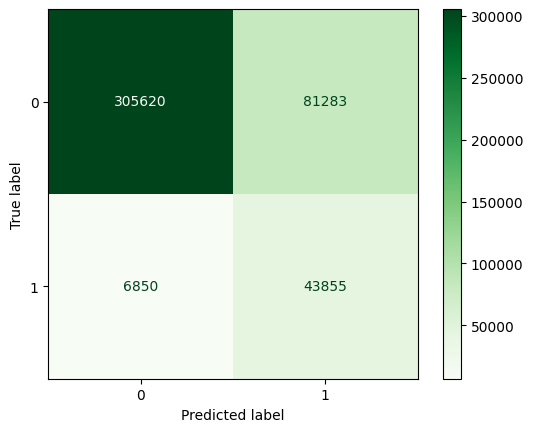

In [32]:
#Plot confusion matrix
cm = confusion_matrix(y_test,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)
disp.plot(cmap='Greens')

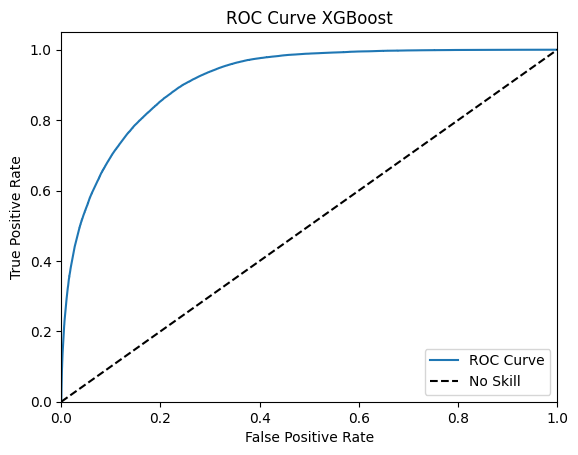

In [33]:
#Generate ROC curve and plot
fpr,tpr, thresholds = roc_curve(y_test,y_proba)
roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC Curve')
plt.plot([0,1],[0,1], 'k--', label = 'No Skill')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGBoost')
plt.legend()
plt.show()

In [34]:
#Data in wide format need to melt into long for visualization
final_results_df_long = pd.melt(
    final_results_df,
    id_vars='Model',
    value_vars=['Accuracy','ROC AUC', 'Precision','Recall','F1'],
    var_name='Metric',
    value_name='Score'
)

In [35]:
final_results_df_long.head()

,Model,Metric,Score
0,XGBoost,Accuracy,0.798603
1,XGBoost,ROC AUC,0.912629
2,XGBoost,Precision,0.350453
3,XGBoost,Recall,0.864905
4,XGBoost,F1,0.498797


In [36]:
#Produce radar plot comparing all metrics associated to final model.
fig = px.line_polar(
    final_results_df_long,
    r='Score',
    theta='Metric',
    line_close=True,
    template='plotly_dark'
    )


fig.update_layout(
    title='XGBoost Metrics',
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0,1]
        ),
        angularaxis=dict(
            direction='clockwise'
        )
    ),
)
fig.update_traces(fill='toself')
fig.show()